In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl
import networkx as nx 
import community
from correlation_helpers import *
from wrangling_helpers import *
from clustering_helpers import *


Pre-requisites:
Please unzip de data folder at the level of this notebook, the rest should run smoothly.

The data was taken from the following link: https://drive.switch.ch/index.php/s/0X3Je6DauQRzD2r 
Name of the folder ***"SP500_2010"***

## Step 1: Constructing return matrix

In [ ]:
log_return_matrix("SP500_2010/SP500_2010",output_dir='log_15_min',aggregation_window='15m')
log_return_matrix("SP500_2010/SP500_2010",output_dir='log_5_min',aggregation_window='5m')
log_return_matrix("SP500_2010/SP500_2010",output_dir='log_30_min',aggregation_window='30m')
log_return_matrix("SP500_2010/SP500_2010",output_dir="log returns",aggregation_window='1h')

In [20]:
#min req 100 for 30 mins is best for now
returns=reconstruct_returns("log_30_min",min_row_requirement=130)

Total return matrix has dimensions (111, 143)


In [78]:

rets_1h=reconstruct_returns("log returns")

Total return matrix has dimensions (86, 143)


## Step 2: Correlation Matrix Cleaning

### EV clipping

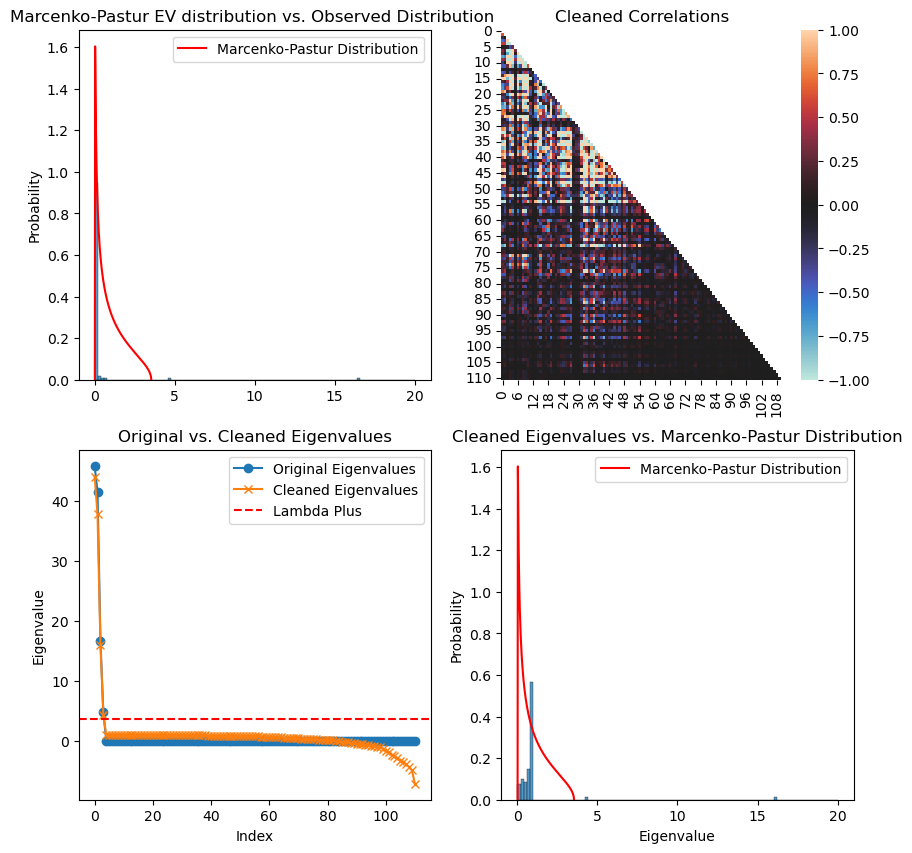

In [4]:
normal_clipping=ev_cleaning(returns,on_timestamp=True,ev_clipping=True)

### C minus C0

#### Taking Market Mode into consideration

c:\Users\Kamal\miniconda3\envs\Fin_Big_Data\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Kamal\miniconda3\envs\Fin_Big_Data\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\Kamal\miniconda3\envs\Fin_Big_Data\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Kamal\miniconda3\envs\Fin_Big_Data\Lib\site-packages\pandas\core\dtypes\astype.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


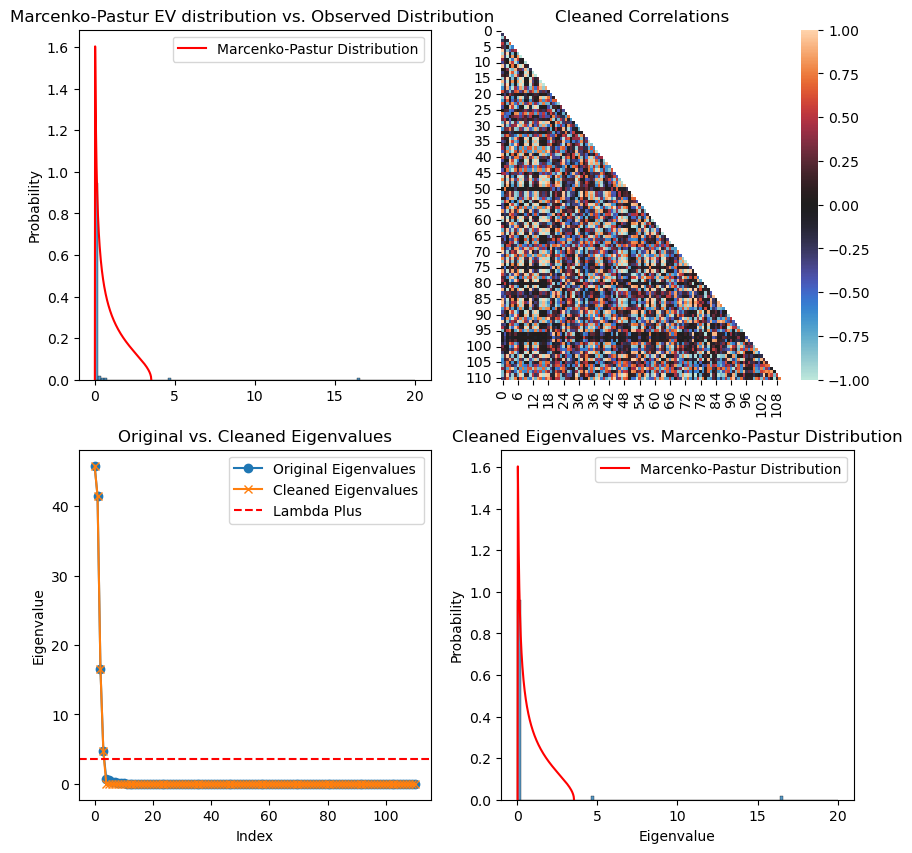

In [5]:
c_c0=ev_cleaning(returns,on_timestamp=True,ev_clipping=False,MarketMode=True)

## Step 3: Clustering

### Louvain

In [56]:
from numpy import linalg as LA
from community import community_louvain
import matplotlib.colors as mcolors

def LouvainCorrelationClustering(R,ev_clipping=False,sparsify=False,epsilon=1e-4):   # R is a matrix of return
    N=R.shape[1]-1
    T=R.shape[0]

    q=N*1./T
    lambda_plus=(1.+np.sqrt(q))**2

    C=np.corrcoef(R.drop('index'))
    lambdas, v = LA.eigh(C)


    if ev_clipping:
        C_s=eigenvalue_clipping(lambdas,v,lambda_plus)
    else:        
        C_s=compute_C_minus_C0(lambdas,v,lambda_plus)

    sns.heatmap(C_s,mask=np.triu(C_s),
            vmin=-1,vmax=1,center= 0)
    plt.title('Cleaned Correlation matrix')

    mygraph=create_graph(C_s,sparsify,epsilon)
        
    timestamps = R.select(pl.col("index")).to_series().to_list()

    for i,time in enumerate(timestamps):
        nx.set_node_attributes(mygraph, {i: {"timestamp": time}})

    partition = community.community_louvain.best_partition(mygraph)
    print(partition)

    #plot_graph(mygraph,partition)
    plot_clustering(mygraph,partition)

    DF=pd.DataFrame.from_dict(partition,orient="index",columns=["Cluster"])
    DF["Timestamp"] = [mygraph.nodes[node]["timestamp"] for node in DF.index]

    return(DF)


{0: 2, 1: 0, 2: 2, 3: 1, 4: 2, 5: 1, 6: 2, 7: 2, 8: 2, 9: 1, 10: 1, 11: 2, 12: 1, 13: 1, 14: 1, 15: 2, 16: 2, 17: 2, 18: 2, 19: 1, 20: 0, 21: 2, 22: 2, 23: 2, 24: 1, 25: 0, 26: 1, 27: 0, 28: 0, 29: 2, 30: 2, 31: 1, 32: 0, 33: 1, 34: 1, 35: 1, 36: 1, 37: 2, 38: 2, 39: 2, 40: 1, 41: 1, 42: 1, 43: 0, 44: 2, 45: 0, 46: 2, 47: 2, 48: 2, 49: 2, 50: 0, 51: 1, 52: 1, 53: 1, 54: 2, 55: 1, 56: 2, 57: 2, 58: 0, 59: 2, 60: 2, 61: 1, 62: 1, 63: 2, 64: 2, 65: 1, 66: 1, 67: 1, 68: 0, 69: 1, 70: 2, 71: 2, 72: 2, 73: 2, 74: 2, 75: 0, 76: 2, 77: 1, 78: 1, 79: 1, 80: 0, 81: 1, 82: 2, 83: 0, 84: 0, 85: 2, 86: 2, 87: 2, 88: 2, 89: 1, 90: 1, 91: 2, 92: 2, 93: 1, 94: 1, 95: 1, 96: 0, 97: 0, 98: 0, 99: 1, 100: 1, 101: 1, 102: 1, 103: 2, 104: 1, 105: 2, 106: 0, 107: 2, 108: 1, 109: 2, 110: 1}


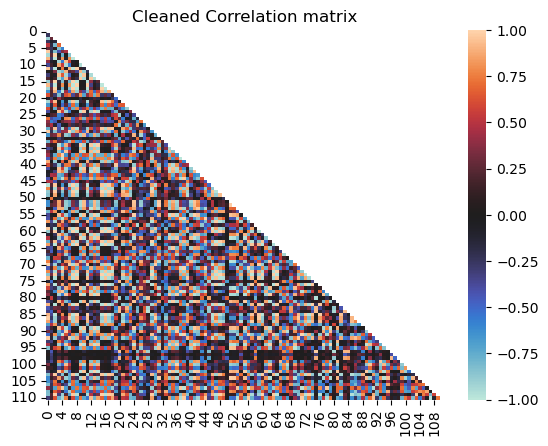

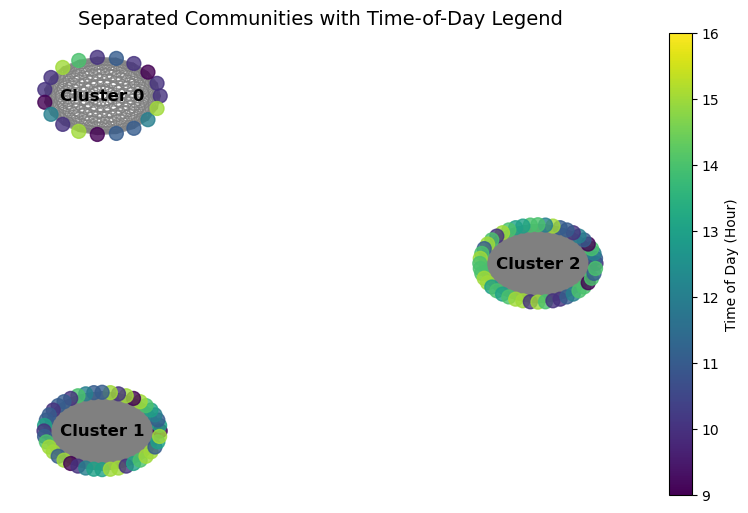

In [9]:
louv_30=LouvainCorrelationClustering(returns,ev_clipping=False,sparsify=False,epsilon=1e-3)

{0: 0, 1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 1, 14: 1, 15: 0, 16: 2, 17: 1, 18: 0, 19: 2, 20: 2, 21: 0, 22: 2, 23: 0, 24: 0, 25: 0, 26: 1, 27: 0, 28: 0, 29: 1, 30: 1, 31: 0, 32: 0, 33: 1, 34: 1, 35: 1, 36: 1, 37: 0, 38: 0, 39: 1, 40: 0, 41: 1, 42: 0, 43: 1, 44: 0, 45: 1, 46: 1, 47: 1, 48: 2, 49: 2, 50: 1, 51: 1, 52: 1, 53: 0, 54: 1, 55: 2, 56: 1, 57: 0, 58: 0, 59: 1, 60: 0, 61: 2, 62: 1, 63: 2, 64: 1, 65: 1, 66: 1, 67: 0, 68: 0, 69: 0, 70: 1, 71: 2, 72: 2, 73: 1, 74: 0, 75: 2, 76: 1, 77: 0, 78: 1, 79: 0, 80: 1, 81: 0, 82: 0, 83: 1, 84: 1, 85: 0}


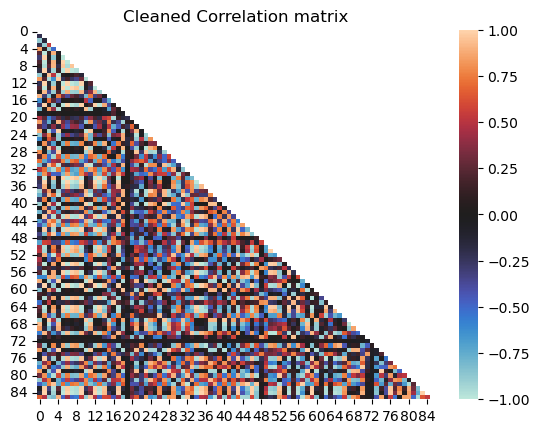

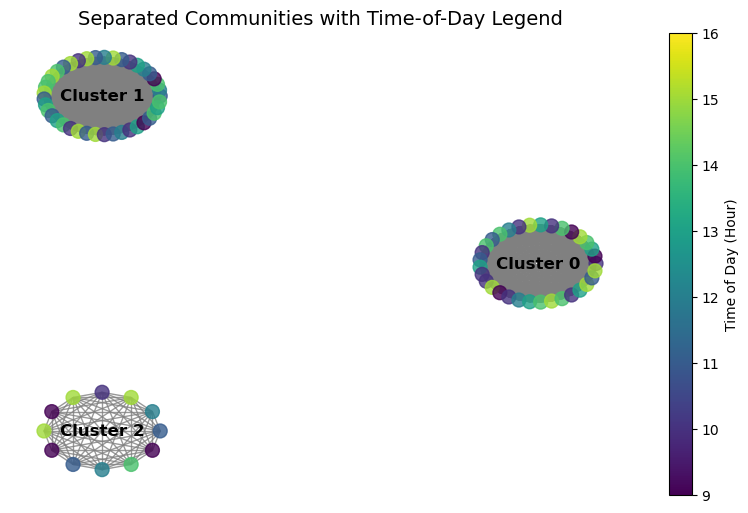

In [80]:
louv_1h=LouvainCorrelationClustering(rets_1h,ev_clipping=False,sparsify=False,epsilon=1e-3)

### Girvan-Newman

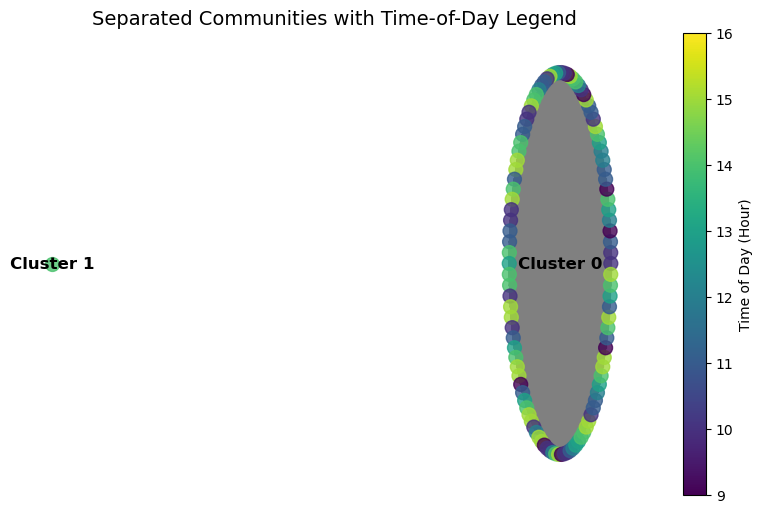

In [22]:
from networkx.algorithms.community import girvan_newman

def GVClustering(R,ev_clipping=False,sparsify=False,epsilon=1e-3):
    N=R.shape[1]-1
    T=R.shape[0]
    
    q=N*1./T
    lambda_plus=(1.+np.sqrt(q))**2
    
    C=np.corrcoef(R.drop('index'))
    lambdas, v = LA.eigh(C)

    if ev_clipping:
        C_s=eigenvalue_clipping(lambdas,v,lambda_plus)
    else:        
        C_s=compute_C_minus_C0(lambdas,v,lambda_plus)
    
    G=create_graph(C_s,sparsify,epsilon)
    timestamps = R.select(pl.col("index")).to_series().to_list()

    for i,time in enumerate(timestamps):
        nx.set_node_attributes(G, {i: {"timestamp": time}})
    communities_generator = girvan_newman(G)
    first_level_communities = next(communities_generator)
    # Get list of communities
    communities = [list(community) for community in first_level_communities]
    partition = {e: cluster for cluster, elems in enumerate(communities) for e in elems}
    #plot_graph(G,partition)
    plot_clustering(G,partition)


GVClustering(returns,ev_clipping=False,sparsify=True)


### Marsili Giada

In [31]:
import itertools
def expand_grid_unique(x, y, include_equals=False):
    x = list(set(x))
    y = list(set(y))

    def g(i):
        z = [val for val in y if val not in x[:i - include_equals]]
        if z:
            return [x[i - 1]] + z

    combinations = [g(i) for i in range(1, len(x) + 1)]
    return [combo for combo in combinations if combo]


def max_likelihood(c, n):
    if n > 1:
        return np.log(n / c) + (n - 1) * np.log((n * n - n) / (n * n - c))
    else:
        return 0
    
def max_likelihood_list(cs, ns):
    Lc = {}
    for x in cs.keys():
        if ns[x] > 1:
            Lc[x] = np.log(ns[x] / cs[x]) + (ns[x] - 1) * np.log((ns[x] * ns[x] - ns[x]) / (ns[x] * ns[x] - cs[x]))
        else:
            Lc[x] = 0
    return Lc

def find_max_improving_pair(C, cs, ns, i_s):
    N = len(i_s)
    Lc_new = {}
    Lc_old = max_likelihood_list(cs, ns)
    names_cs = list(cs.keys())
    max_impr = -1e10
    pair_max_improv = []
    
    for i in names_cs[:-1]:
        names_cs_j = names_cs[names_cs.index(i) + 1:]
        for j in names_cs_j:
            ns_new = ns[i] + ns[j]
            i_s_new = i_s[i] + i_s[j]
          #  ipdb.set_trace()
            cs_new = np.sum(C[np.ix_(i_s_new, i_s_new)])
            max_likelihood_new = max_likelihood(cs_new, ns_new)
            improvement = max_likelihood_new - Lc_old[i] - Lc_old[j]

            if improvement > max_impr:
                max_impr = improvement
                pair_max_improv = [i, j]
                Lc_max_impr = max_likelihood_new
#    print(pair_max_improv)
#    print(max_impr)
#    print(Lc_max_impr)
#    print("*************")

    return {"pair": pair_max_improv, "Lc_new": Lc_max_impr, "Lc_old": [Lc_old[x] for x in pair_max_improv]}


def aggregate_clusters(C, only_log_likelihood_improving_merges=False):
    N = C.shape[0]
    cs = {i: 1 for i in range(N)}
    s_i = {i: [i] for i in range(N)}
    ns = {i: 1 for i in range(N)}
    i_s = {i: [i] for i in range(N)}
    Lc = {i: 0 for i in range(N)}
    
    all_pairs = [(i, j) for i in range(1, N + 1) for j in range(1, N + 1)]

    clusters = []
    for i in range(1, N):  # hierarchical merging
#        print(i)
        improvement = find_max_improving_pair(C, cs, ns, i_s)
        Lc_old = improvement['Lc_old']
        Lc_new = improvement['Lc_new']
        
        if Lc_new < sum(Lc_old):
            print(" HALF CLUSTER  Lc.new > max(Lc.old)")
            # browser()
            
        if Lc_new <= max(Lc_old):
            print("Lc.new <= max(Lc.old), exiting")
            break
            
        pair = improvement['pair']
        s_i = [pair[0] if x == pair[1] else x for x in s_i]
    
        cluster1 = pair[0]
        cluster2 = pair[1]
        i_s[cluster1].extend(i_s[cluster2])  # merge the elements of the two clusters
        del i_s[cluster2]  # removes reference to merged cluster2
    
        ns[cluster1] += ns[cluster2]
        del ns[cluster2]
        cs[cluster1] = np.sum(C[i_s[cluster1]][:, i_s[cluster1]])  # sums C over the elements of cluster1
        del cs[cluster2]
    
        cs_vec = list(cs.values())
        ns_vec = list(ns.values())
    
        clusters.append({
            'Lc': max_likelihood_list(cs, ns),
            'pair_merged': pair,
            's_i': s_i,
            'i_s': i_s,
            'cs': cs,
            'ns': ns
        })
    
    last_clusters = clusters[-1]

    return last_clusters

In [32]:
def MG_Clustering(R,ev_clipping=False,ev_cleaning=False):
    N=R.shape[1]-1
    T=R.shape[0]
    
    q=N*1./T
    lambda_plus=(1.+np.sqrt(q))**2
    
    C=np.corrcoef(R.drop('index'))
    lambdas, v = LA.eigh(C)

    if ev_cleaning:
            if ev_clipping:
                C=eigenvalue_clipping(lambdas,v,lambda_plus)
            else:        
                C=compute_C_minus_C0(lambdas,v,lambda_plus)

    return aggregate_clusters(C), C
    

In [33]:
def visualize_MG(R,res_dict,corr,sparsify=False):
    G=create_graph(corr,sparsify)
    partition={i:clust for i,clust in enumerate(res_dict['s_i'])}
    timestamps = R.select(pl.col("index")).to_series().to_list()
    for i,time in enumerate(timestamps):
        nx.set_node_attributes(G, {i: {"timestamp": time}})
    #plot_graph(G,partition)
    plot_clustering(G,partition,drop_small=True,draw_label=True)



C:\Users\Kamal\AppData\Local\Temp\ipykernel_43204\2922250596.py:17: RuntimeWarning: invalid value encountered in log
  return np.log(n / c) + (n - 1) * np.log((n * n - n) / (n * n - c))


 HALF CLUSTER  Lc.new > max(Lc.old)
Lc.new <= max(Lc.old), exiting


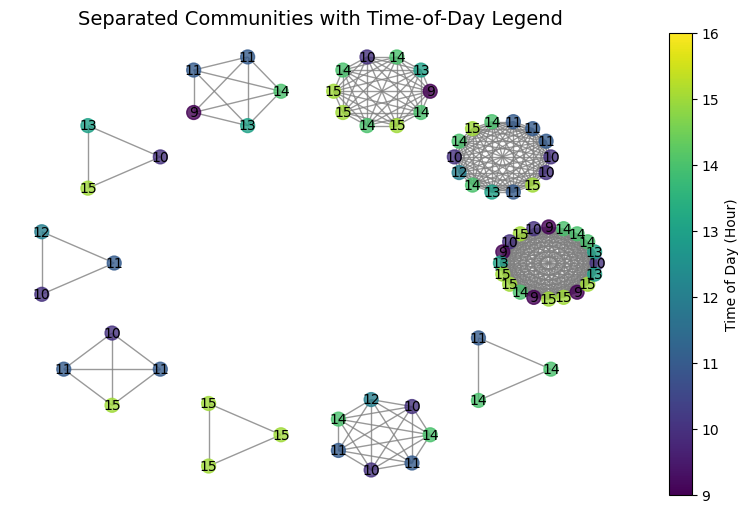

In [34]:
res,C=MG_Clustering(returns,ev_cleaning=True,ev_clipping=True)
visualize_MG(returns,res,C)

 HALF CLUSTER  Lc.new > max(Lc.old)
 HALF CLUSTER  Lc.new > max(Lc.old)
 HALF CLUSTER  Lc.new > max(Lc.old)
 HALF CLUSTER  Lc.new > max(Lc.old)
 HALF CLUSTER  Lc.new > max(Lc.old)
Lc.new <= max(Lc.old), exiting


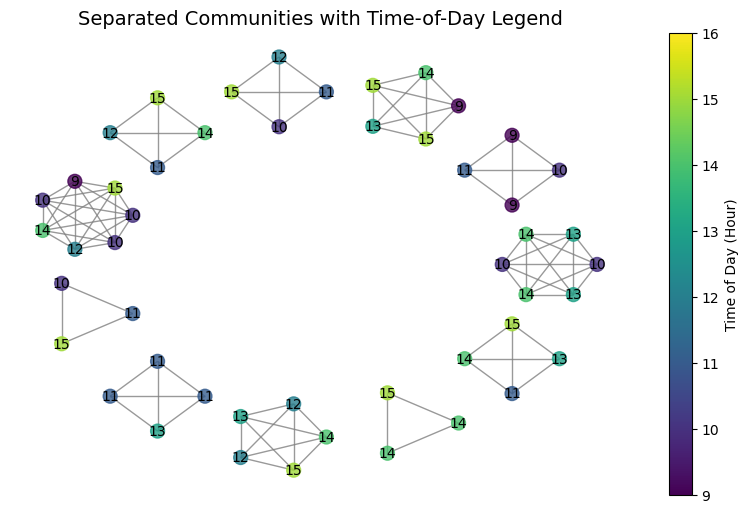

In [35]:
res_C0,C_C0=MG_Clustering(returns,ev_cleaning=True,ev_clipping=False)
visualize_MG(returns,res_C0,C_C0,sparsify=True)

 HALF CLUSTER  Lc.new > max(Lc.old)
Lc.new <= max(Lc.old), exiting


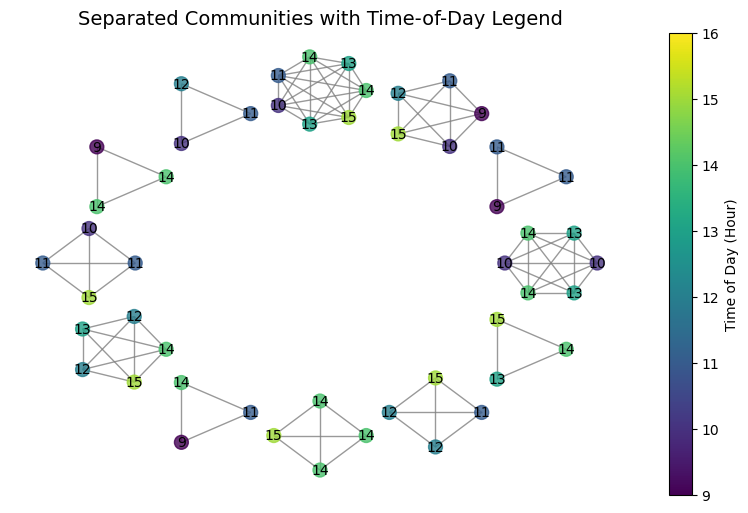

In [37]:
res_raw,C_raw=MG_Clustering(returns,ev_cleaning=False,ev_clipping=False)
visualize_MG(returns,res_raw,C_raw,sparsify=True)

C:\Users\Kamal\AppData\Local\Temp\ipykernel_43204\2922250596.py:17: RuntimeWarning: invalid value encountered in log
  return np.log(n / c) + (n - 1) * np.log((n * n - n) / (n * n - c))


 HALF CLUSTER  Lc.new > max(Lc.old)
Lc.new <= max(Lc.old), exiting


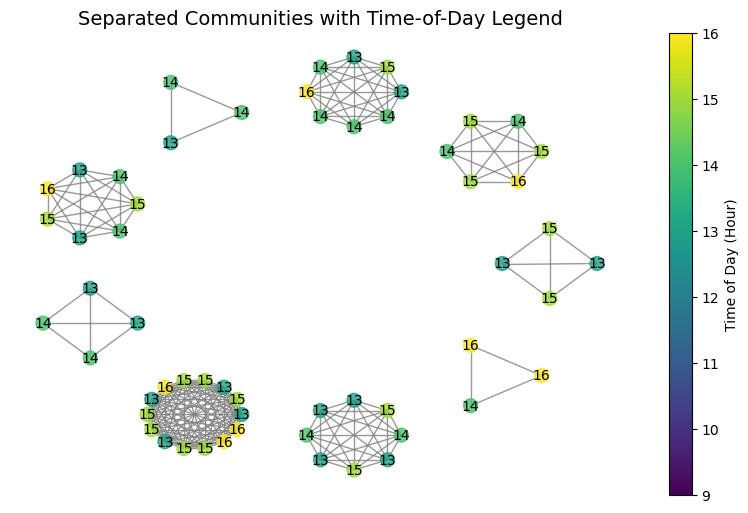

In [36]:
res_y,C_y=MG_Clustering(rets_1hsin,ev_cleaning=True,ev_clipping=True)
visualize_MG(rets_1hsin,res_y,C_y)

###

## Step 4: Evaluation

In [81]:
def calculate_time_homogeneity(df):
    cur_df=df.copy()
    cur_df['hours']=pd.to_datetime(cur_df['Timestamp'].dt.strftime('%H:%M'))
    clusters = df['Cluster'].unique()
    homogeneity = {}
    for cluster in clusters:
        timestamps = cur_df[df['Cluster'] == cluster]['hours']
        # Convert to numeric (seconds since epoch) for variance calculation
        timestamps_numeric =( timestamps.astype(np.int64) // 10**9)/3600
        variance = np.var(timestamps_numeric)
        homogeneity[cluster] = variance
    return homogeneity

# Temporal Modularity: Difference between consecutive timestamps within each cluster
def calculate_temporal_modularity(df):
    cur_df=df.copy()
    cur_df['hours']=pd.to_datetime(cur_df['Timestamp'].dt.strftime('%H:%M'))
    modularity = {}
    for cluster in cur_df['Cluster'].unique():
        timestamps = cur_df[cur_df['Cluster'] == cluster]['hours'].sort_values()
        differences = np.diff((timestamps.astype(np.int64) // 10**9)/3600)  # Time differences in seconds
        modularity[cluster] = np.mean(differences)
    return modularity

def plot_metrics(df,time_homogeneity,temporal_modularity):
    cur_df=df.copy()
    cur_df['hours']=pd.to_datetime(cur_df['Timestamp'].dt.strftime('%H:%M')).astype(np.int64)\
                    .apply(lambda x:((x//10**9)/3600))

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].bar(time_homogeneity.keys(), time_homogeneity.values(), color='skyblue')
    axes[0].set_title('Time Homogeneity (Variance of Timestamps)')
    axes[0].set_xlabel('Cluster')
    axes[0].set_ylabel('Variance (Hours squared)')
    axes[0].axhline(cur_df['hours'].var(),color='red',label='general time variance')
    axes[0].legend()

    # Plot Temporal Modularity
    axes[1].bar(temporal_modularity.keys(), temporal_modularity.values())
    axes[1].set_title('Temporal Modularity (Mean Time Difference)')
    axes[1].set_xlabel('Cluster')
    axes[1].set_ylabel('Mean Time Difference (Hours)')
    axes[1].axhline(cur_df['hours'].diff().mean(),color='red',label='general time difference')
    axes[1].legend()



    plt.tight_layout()
    plt.show()

In [82]:
hom_30=calculate_time_homogeneity(louv_30)
hom_1h=calculate_time_homogeneity(louv_1h)
mod_30=calculate_temporal_modularity(louv_30)
mod_1h=calculate_temporal_modularity(louv_1h)

C:\Users\Kamal\AppData\Local\Temp\ipykernel_39096\1632974006.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cur_df['hours']=pd.to_datetime(cur_df['Timestamp'].dt.strftime('%H:%M'))
C:\Users\Kamal\AppData\Local\Temp\ipykernel_39096\1632974006.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cur_df['hours']=pd.to_datetime(cur_df['Timestamp'].dt.strftime('%H:%M'))
C:\Users\Kamal\AppData\Local\Temp\ipykernel_39096\1632974006.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cur_df['hours']=pd.to_datetime(cur_df['Timestamp'].dt.strftime('%H:%M'))
C:\Users\Kamal\AppDat

C:\Users\Kamal\AppData\Local\Temp\ipykernel_39096\1632974006.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cur_df['hours']=pd.to_datetime(cur_df['Timestamp'].dt.strftime('%H:%M')).astype(np.int64)\


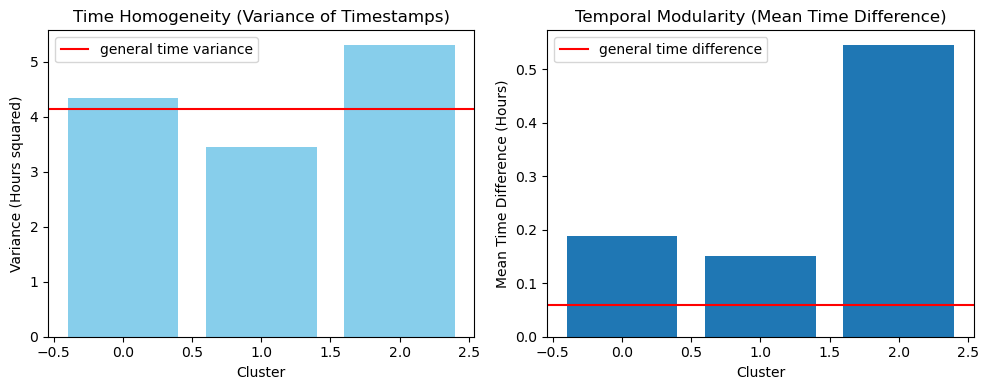

In [83]:
plot_metrics(louv_1h,hom_1h,mod_1h)

C:\Users\Kamal\AppData\Local\Temp\ipykernel_39096\1632974006.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cur_df['hours']=pd.to_datetime(cur_df['Timestamp'].dt.strftime('%H:%M')).astype(np.int64)\


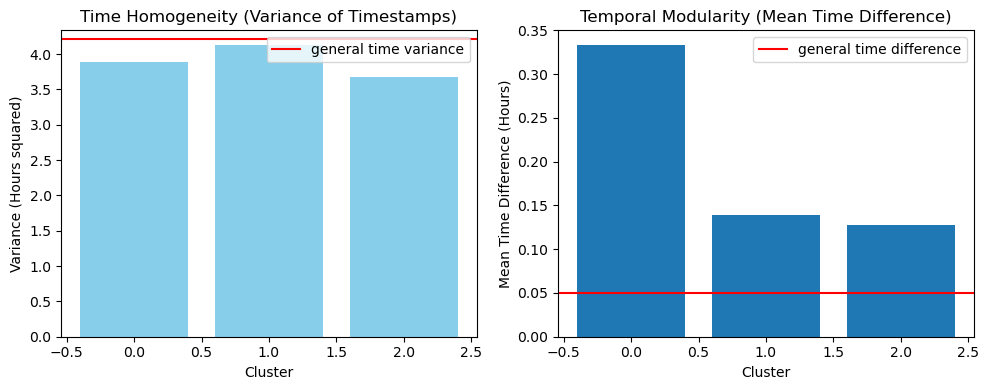

In [37]:
plot_metrics(louv_30,hom_30,mod_30)

##### Plotting timestamp distribution

In [98]:
def plot_cluster_distribution(l_df,ecdf=False):
    plt.figure(figsize=(24,6))
    all_times = (
        l_df['Timestamp'].dt.strftime('%H:%M').unique()
    )  
    all_times_sorted = sorted(all_times)

    for cluster in l_df['Cluster'].unique():
                cur_df=l_df[l_df['Cluster']==cluster]
                times = cur_df['Timestamp'].dt.strftime('%H:%M')
                times = pd.Categorical(times, categories=all_times_sorted, ordered=True)
                if ecdf:
                        sns.ecdfplot(times,label=f'Cluster {cluster}')
                else:
                    sns.histplot(times,stat='density',
                                kde=True,label=f'Cluster {cluster}',bins=5)
    plt.title('Distribution of Cluster members')
    plt.tight_layout()
    plt.legend()

#### 1h

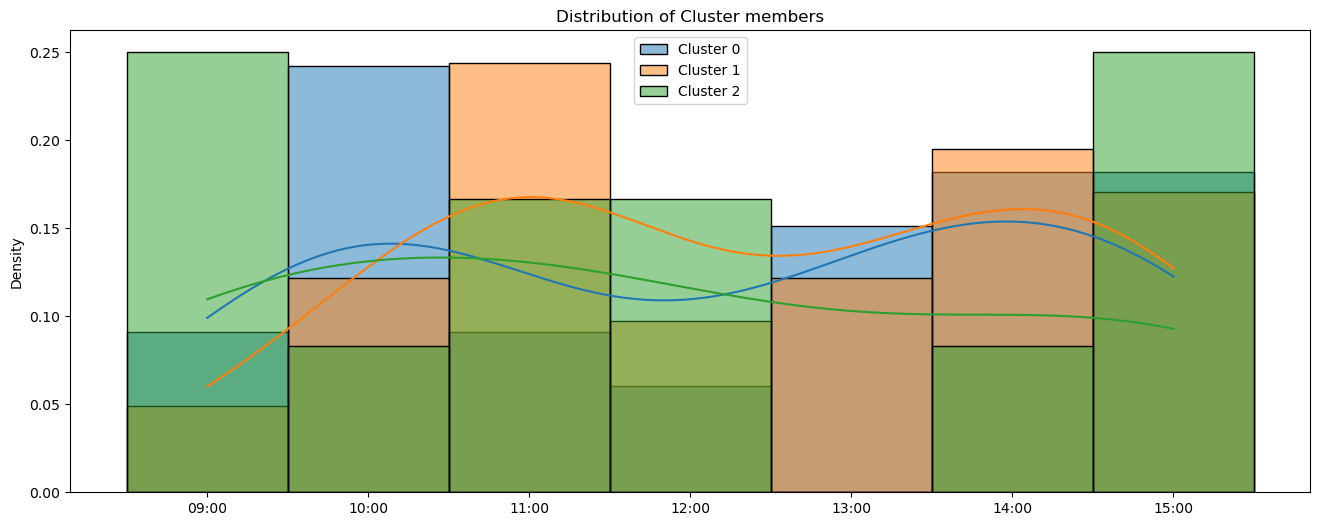

In [76]:
plot_cluster_distribution(louv_1h)

#### 30 mins

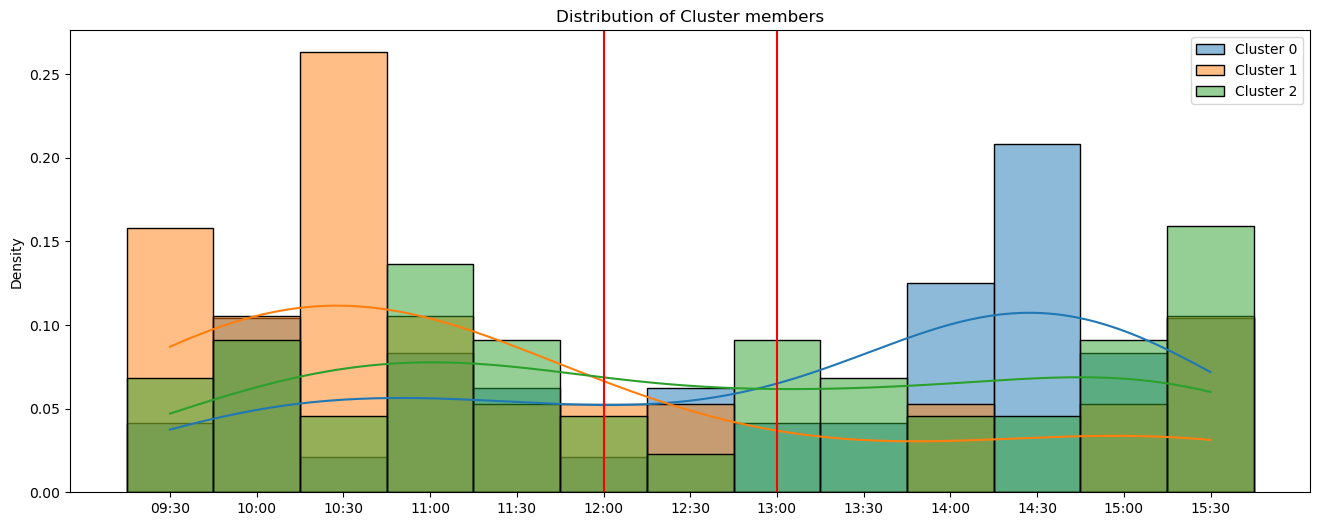

In [211]:
plot_cluster_distribution(louv_30)
plt.axvline('12:00',color='red')
plt.axvline('13:00',color='red')

### Step 4.1: Further reduction of granularity

#### 15 minutes

In [65]:
rets_15=reconstruct_returns('log_15_min',min_row_requirement=300)

Total return matrix has dimensions (118, 143)


{0: 0, 1: 2, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 1, 14: 0, 15: 0, 16: 0, 17: 1, 18: 0, 19: 0, 20: 1, 21: 1, 22: 0, 23: 1, 24: 0, 25: 0, 26: 2, 27: 1, 28: 2, 29: 2, 30: 0, 31: 2, 32: 2, 33: 0, 34: 1, 35: 0, 36: 1, 37: 2, 38: 1, 39: 0, 40: 0, 41: 0, 42: 1, 43: 1, 44: 1, 45: 1, 46: 0, 47: 1, 48: 0, 49: 0, 50: 0, 51: 0, 52: 2, 53: 1, 54: 1, 55: 1, 56: 1, 57: 0, 58: 0, 59: 0, 60: 1, 61: 2, 62: 1, 63: 0, 64: 2, 65: 1, 66: 2, 67: 2, 68: 2, 69: 1, 70: 0, 71: 0, 72: 1, 73: 0, 74: 0, 75: 0, 76: 0, 77: 1, 78: 1, 79: 1, 80: 1, 81: 2, 82: 0, 83: 1, 84: 2, 85: 2, 86: 0, 87: 0, 88: 1, 89: 0, 90: 0, 91: 0, 92: 1, 93: 2, 94: 2, 95: 1, 96: 0, 97: 0, 98: 1, 99: 2, 100: 1, 101: 1, 102: 2, 103: 2, 104: 2, 105: 2, 106: 1, 107: 1, 108: 2, 109: 1, 110: 0, 111: 1, 112: 0, 113: 1, 114: 1, 115: 0, 116: 1, 117: 0}


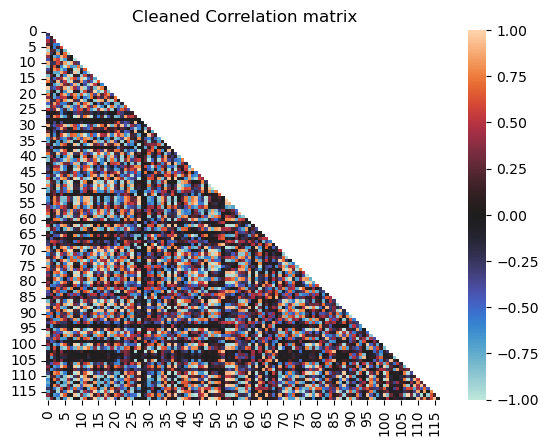

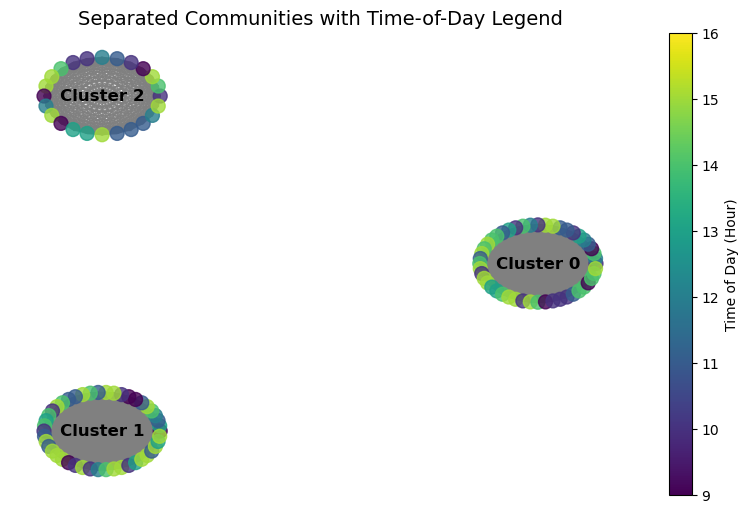

In [66]:
louv_15=LouvainCorrelationClustering(rets_15)

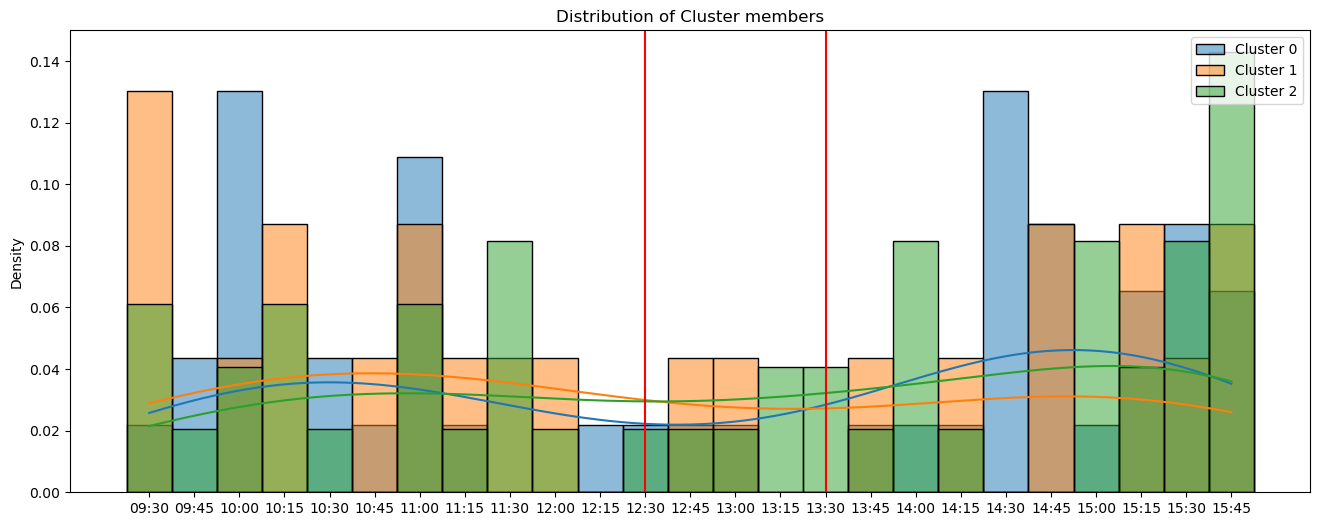

In [25]:
plot_cluster_distribution(louv_15)
plt.axvline('12:30',color='red')
plt.axvline('13:30',color='red')

C:\Users\Kamal\AppData\Local\Temp\ipykernel_39096\1632974006.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cur_df['hours']=pd.to_datetime(cur_df['Timestamp'].dt.strftime('%H:%M'))
C:\Users\Kamal\AppData\Local\Temp\ipykernel_39096\1632974006.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cur_df['hours']=pd.to_datetime(cur_df['Timestamp'].dt.strftime('%H:%M'))
C:\Users\Kamal\AppData\Local\Temp\ipykernel_39096\1632974006.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cur_df['hours']=pd.to_datetime(cur_df['Timestamp'].dt.strftime('%H:%M')).astype(np.int64)\


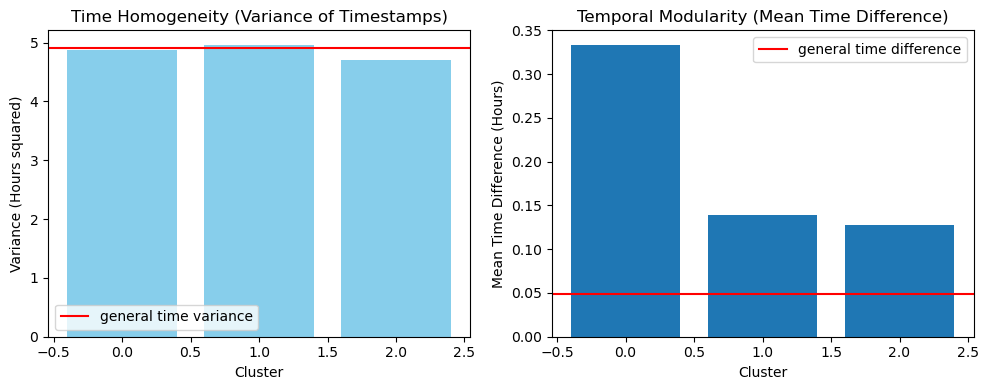

In [38]:
hom_15=calculate_time_homogeneity(louv_15)
mod_15=calculate_temporal_modularity(louv_30)
plot_metrics(louv_15,hom_15,mod_15)

#### 5 minutes

In [70]:
rets_5=reconstruct_returns('log_5_min',min_row_requirement=300)

Total return matrix has dimensions (66, 143)


{0: 0, 1: 2, 2: 0, 3: 2, 4: 0, 5: 2, 6: 0, 7: 1, 8: 2, 9: 2, 10: 2, 11: 1, 12: 2, 13: 0, 14: 0, 15: 2, 16: 0, 17: 1, 18: 0, 19: 2, 20: 1, 21: 0, 22: 1, 23: 0, 24: 0, 25: 1, 26: 2, 27: 1, 28: 1, 29: 2, 30: 2, 31: 1, 32: 0, 33: 1, 34: 1, 35: 0, 36: 0, 37: 2, 38: 2, 39: 2, 40: 0, 41: 1, 42: 1, 43: 1, 44: 1, 45: 0, 46: 0, 47: 1, 48: 0, 49: 0, 50: 2, 51: 1, 52: 1, 53: 0, 54: 0, 55: 1, 56: 0, 57: 2, 58: 0, 59: 0, 60: 0, 61: 1, 62: 0, 63: 2, 64: 1, 65: 2}


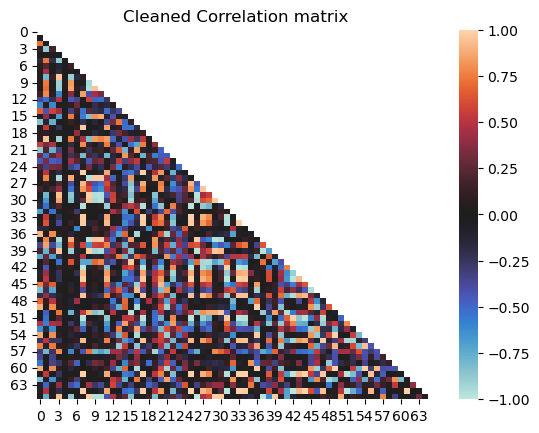

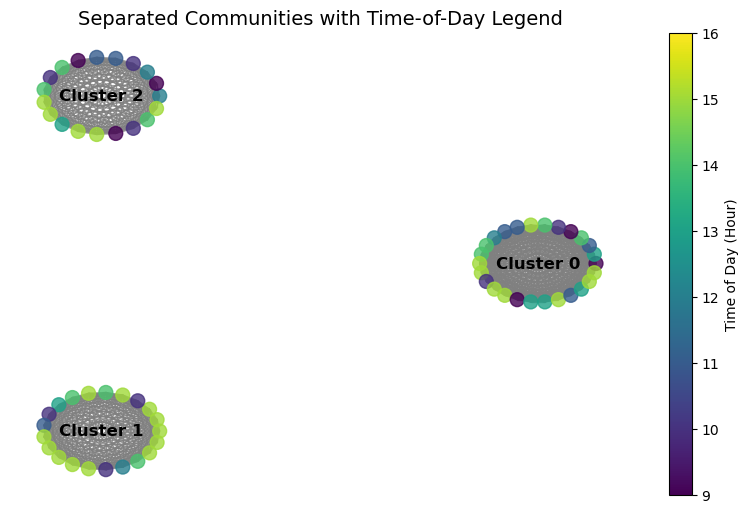

In [71]:
louv_5=LouvainCorrelationClustering(rets_5)

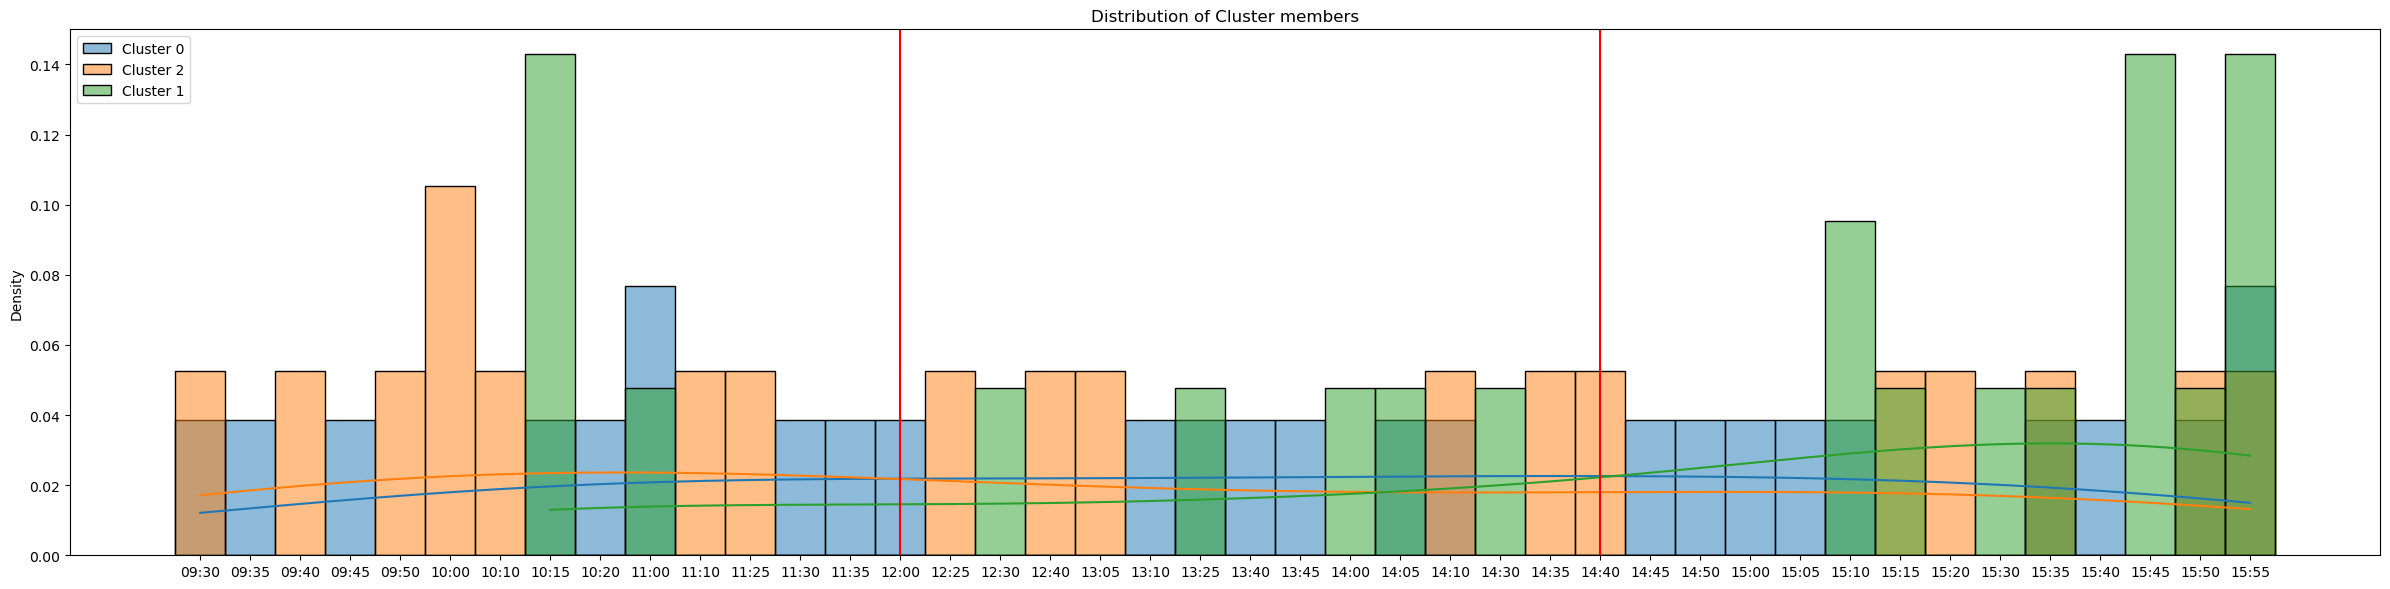

In [100]:
plot_cluster_distribution(louv_5)
plt.axvline('12:00',color='red')
plt.axvline('14:40',color='red')


## Step 5: Further Analysis

In [80]:
louv_15
louv_15["period"] = louv_15["Cluster"].apply(
    lambda x: "end-of-day" if x == 0 else "morning" if x == 1 else "mid-day"
)

In [84]:
louv_15

,Cluster,Timestamp,period
0,0,2010-05-03 10:00:00-04:00,end-of-day
1,2,2010-05-03 10:45:00-04:00,mid-day
2,1,2010-05-04 09:30:00-04:00,morning
3,0,2010-05-04 12:15:00-04:00,end-of-day
4,1,2010-05-04 13:15:00-04:00,morning
...,...,...,...
113,1,2010-05-27 15:45:00-04:00,morning
114,1,2010-05-28 13:00:00-04:00,morning
115,0,2010-05-28 14:30:00-04:00,end-of-day
116,1,2010-05-28 15:30:00-04:00,morning


In [88]:
transition_counts = pd.crosstab(
    louv_15["period"],  # From cluster
    louv_15["period"].shift(-1),  # To cluster
    dropna=True
)
transition_counts = transition_counts.reindex(index=["morning", "mid-day", "end-of-day"], columns=["morning", "mid-day", "end-of-day"], fill_value=0)
transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0).fillna(0)
#transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0).fillna(0)


In [86]:
transition_matrix

period,morning,mid-day,end-of-day
period,,,
morning,0.326087,0.217391,0.456522
mid-day,0.458333,0.375000,0.166667
end-of-day,0.425532,0.106383,0.468085


In [89]:
eigvals, eigvecs = np.linalg.eig(transition_matrix.T)
stationary_dist = eigvecs[:, np.isclose(eigvals, 1)].flatten().real
stationary_dist /= stationary_dist.sum()  # Normalize
print("Stationary Distribution:", stationary_dist)


Stationary Distribution: [0.39316239 0.20512821 0.4017094 ]


In [74]:
sojourn_times = 1 / (1 - np.diag(transition_matrix))
print("Sojourn Times:", sojourn_times)


Sojourn Times: [1.88       1.48387097 1.6       ]


In [ ]:
def simulate_markov_chain(transition_matrix, start_state, steps):
    state = start_state
    sequence = [state]
    for _ in range(steps):
        state = np.random.choice(
            len(transition_matrix), p=transition_matrix[state]
        )
        sequence.append(state)
    return sequence

simulated_sequence = simulate_markov_chain(transition_matrix.values, start_state=0, steps=100)
print("Simulated Cluster Sequence:", simulated_sequence)
